In [ ]:
# =============================================================================
# 1. CONFIGURACIÓN E IMPORTACIONES
# =============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os, random
import joblib
from tqdm import tqdm

# Scikit-Learn
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import Ridge # Importamos Ridge

# XGBoost
import xgboost as xgb

# TensorFlow / Keras (LSTM)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Modelos de Panel
from linearmodels.panel import PanelOLS
import statsmodels.api as sm

# Configuración Global
warnings.filterwarnings('ignore')
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 7)

SEED = 505
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

# =============================================================================
# 2. CARGA DE DATOS Y PREPARACIÓN
# =============================================================================
url = "https://raw.githubusercontent.com/rortizgeo/Maestria_CD_Proyecto-Aplicado/main/Data_final.csv"
try:
    df_raw = pd.read_csv(url)
    print("Datos cargados desde URL.")
except:
    # Fallback local
    df_raw = pd.read_csv("Data_final.csv")
    print("Datos cargados localmente.")

df_raw['ds'] = pd.to_datetime(df_raw['year'], format='%Y')
df_raw = df_raw[df_raw['country'] != 'United States'].reset_index(drop=True)
df_raw = df_raw.sort_values(by=['country', 'ds']).reset_index(drop=True)

TARGET = 'occurrenceCount_publisher'
df_raw[TARGET] = np.log1p(df_raw[TARGET])

# Features base (Sin Lags)
features_base = [
    'gasto_RD_pib', 'efectividad_gobierno', 'uso_internet', 
    'pib_per_capita', 'inscripcion_primaria', 
    'inscripcion_secundaria',
    'inscripcion_terciaria',
    'areas_protegidas',      
    'gasto_educacion_pib', 'investigadores_RD', 'art_cientificos',
    'gbif_member', 'ogp_membership'
]



2026-01-07 22:08:20.012460: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Datos cargados desde URL.


In [2]:
# =============================================================================
# 3. DIAGNÓSTICO DE VARIABLES (FE & LASSO) - AJUSTADO
# =============================================================================
def run_diagnostics(df, features):
    print("\n--- 1. DIAGNÓSTICO DE VARIABLES ---")
    
    # Lista negra de variables estáticas SOLO para Efectos Fijos
    # (Estas variables causan AbsorbingEffectError porque no cambian o cambian muy poco en el tiempo)
    static_vars = ['areas_protegidas', 'region', 'incomeLevel', 'countryCode'] 
    
    # Filtramos las features para quedarnos solo con las dinámicas
    features_dynamic = [f for f in features if f not in static_vars]
    
    df_panel = df.set_index(['country', 'year'])
    
    # Limpiamos NaNs asegurando que solo usamos las columnas dinámicas + target
    df_clean = df_panel[features_dynamic + [TARGET]].dropna()
    
    # Verificación de seguridad: ¿Quedan datos?
    if len(df_clean) == 0:
        print("⚠️ Advertencia: Al limpiar NaNs para FE, el dataset quedó vacío.")
        return None

    exog = sm.add_constant(df_clean[features_dynamic])
    
    try:
        mod_fe = PanelOLS(df_clean[TARGET], exog, entity_effects=True)
        # drop_absorbed=True ayuda a que la librería maneje el error automáticamente
        res_fe = mod_fe.fit(cov_type='clustered', cluster_entity=True, auto_df=True)

        print(">>> Variables Significativas (FE p<0.05):")
        print(res_fe.params[res_fe.pvalues < 0.05])
        return res_fe
        
    except Exception as e:
        print(f"⚠️ El diagnóstico FE no pudo converger (probablemente por variables constantes): {e}")
        print("Continuando con el flujo de ML...")
        return None

# Ejecutamos con la lista completa, la función se encarga de filtrar
_ = run_diagnostics(df_raw, features_base)


--- 1. DIAGNÓSTICO DE VARIABLES ---
>>> Variables Significativas (FE p<0.05):
uso_internet    0.143462
gbif_member     4.479134
Name: parameter, dtype: float64


In [3]:
# =============================================================================
# 4. PREPARACIÓN DE DATOS (TABULAR Y SECUENCIAL)
# =============================================================================

# Función de Ingeniería Temporal
def create_temporal_features(df, features_input, lags=[1, 3, 5 ], roll_win=[3, 5]):
    df_out = df.copy()
    # Aseguramos que las variables a transformar sean numéricas
    vars_to_transform = features_input + [TARGET]
    
    for col in vars_to_transform:
        if col not in df_out.columns: continue # Seguridad
        
        for l in lags:
            df_out[f'{col}_lag{l}'] = df_out.groupby('country')[col].shift(l)
        for w in roll_win:
            df_out[f'{col}_roll_mean{w}'] = df_out.groupby('country')[col].shift(1).rolling(w).mean()
    return df_out

# Generar DataFrame Maestro
df_ml = create_temporal_features(df_raw, features_base)
df_ml = df_ml.dropna().reset_index(drop=True)

# Seleccionamos explícitamente solo columnas NUMÉRICAS
# y excluimos columnas que no son predictoras (ids, años, target)
cols_exclude = ['year', 'ds', TARGET, 'country', 'countryCode', 'iso2', 'code'] # 
numeric_cols = df_ml.select_dtypes(include=[np.number]).columns.tolist()
features_tabular = [c for c in numeric_cols if c not in cols_exclude]

# Filtramos para que NO entren lags del target 
#features_tabular = [c for c in numeric_cols if c not in cols_exclude and TARGET not in c]

print(f"✅ Features seleccionadas ({len(features_tabular)}):")
print(features_tabular)

# Preparar Datos Tabulares (X, y)
X_tab = df_ml[features_tabular]
y_tab = df_ml[TARGET]

# Preparar Datos Secuenciales (LSTM) - GLOBAL
def create_lstm_sequences_global(df, features, target, look_back=3):
    X_seq, y_seq, years, countries = [], [], [], []
    
    # Validar que features existen y son numéricas
    valid_features = [f for f in features if f in df.columns and pd.api.types.is_numeric_dtype(df[f])]
    
    for country in df['country'].unique():
        df_country = df[df['country'] == country].sort_values('year')
        
        if len(df_country) == 0: continue
            
        X_country = df_country[valid_features].values.astype(np.float32)
        y_country = df_country[target].values.astype(np.float32)
        years_country = df_country['year'].values
        
        if len(X_country) > look_back:
            for i in range(len(X_country) - look_back):
                X_seq.append(X_country[i:(i + look_back)])
                y_seq.append(y_country[i + look_back])
                years.append(years_country[i + look_back])
                countries.append(country)
    return np.array(X_seq), np.array(y_seq), np.array(years), np.array(countries)

look_back = 3
X_seq, y_seq, years_seq, countries_seq = create_lstm_sequences_global(df_raw, features_base, TARGET, look_back)

print(f"Datos listos. Features Tabulares: {len(features_tabular)}. Secuencias LSTM: {len(X_seq)}")

✅ Features seleccionadas (87):
['superficie_total_km2', 'areas_protegidas', 'gasto_RD_pib', 'efectividad_gobierno', 'art_cientificos', 'uso_internet', 'pib_per_capita', 'inscripcion_primaria', 'inscripcion_secundaria', 'inscripcion_terciaria', 'gasto_educacion_gobierno', 'gasto_educacion_pib', 'investigadores_RD', 'region', 'incomeLevel', 'gbif_member', 'ogp_membership', 'gasto_RD_pib_lag1', 'gasto_RD_pib_lag3', 'gasto_RD_pib_lag5', 'gasto_RD_pib_roll_mean3', 'gasto_RD_pib_roll_mean5', 'efectividad_gobierno_lag1', 'efectividad_gobierno_lag3', 'efectividad_gobierno_lag5', 'efectividad_gobierno_roll_mean3', 'efectividad_gobierno_roll_mean5', 'uso_internet_lag1', 'uso_internet_lag3', 'uso_internet_lag5', 'uso_internet_roll_mean3', 'uso_internet_roll_mean5', 'pib_per_capita_lag1', 'pib_per_capita_lag3', 'pib_per_capita_lag5', 'pib_per_capita_roll_mean3', 'pib_per_capita_roll_mean5', 'inscripcion_primaria_lag1', 'inscripcion_primaria_lag3', 'inscripcion_primaria_lag5', 'inscripcion_primaria

In [4]:
# =============================================================================
# 5. HIPERPARÁMETROS Y OPTIMIZACIÓN
# =============================================================================

# RF
rf_param_dist = {
    "n_estimators": [100, 300, 500, 700],
    "max_depth": [10, 20, 40, None],
    "min_samples_leaf": [1, 2, 5, 10],
    "max_features": [0.7, 0.9, 'sqrt']
}


# LSTM
lstm_param_grid = [
    {"units": 32, "dropout": 0.2, "epochs": 20, "batch_size": 16, "lr": 0.005, "activation": "relu"},
    {"units": 64, "dropout": 0.3, "epochs": 30, "batch_size": 32, "lr": 0.001, "activation": "tanh"},
    {"units": 50, "dropout": 0.3, "epochs": 30, "batch_size": 32, "lr": 0.005, "activation": "tanh"}
]

# Funciones de Optimización
def optimize_random_forest(X_train, y_train, param_dist=rf_param_dist):
    rf = RandomForestRegressor(random_state=SEED, n_jobs=-1)
    search = RandomizedSearchCV(rf, param_distributions=param_dist, n_iter=20, scoring="neg_mean_absolute_error", cv=5, random_state=SEED)
    search.fit(X_train, y_train)
    return search.best_estimator_, search.best_params_

def optimize_lstm(X_train, y_train, look_back, param_grid=lstm_param_grid):
    best_model, best_mae = None, float("inf")
    best_params = {}
    
    # Split interno para validación (Early Stopping)
    # Importante: Shuffle=False para mantener orden temporal si fuera serie única, 
    X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, test_size=0.1, random_state=SEED, shuffle=False)
    
    es = EarlyStopping(monitor='val_loss', mode='min', patience=5, verbose=0, restore_best_weights=True)
    
    for params in param_grid:
        model = Sequential([
            LSTM(params["units"], activation=params["activation"], input_shape=(look_back, X_train.shape[2])),
            Dropout(params["dropout"]),
            Dense(1)
        ])
        optimizer = tf.keras.optimizers.Adam(learning_rate=params['lr'])
        model.compile(optimizer=optimizer, loss="mae")
        
        model.fit(X_t, y_t, epochs=params["epochs"], batch_size=params["batch_size"], 
                  validation_data=(X_v, y_v), callbacks=[es], verbose=0)
        
        preds = model.predict(X_v, verbose=0).flatten()
        mae = mean_absolute_error(y_v, preds)
        
        if mae < best_mae:
            best_mae, best_model = mae, model
            best_params = params
            
    return best_model, best_params

In [5]:
from sklearn.base import BaseEstimator, RegressorMixin
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV

# 1. CREACIÓN DE WRAPPER PARA EVITAR PROBLEMAS DE COMPATIBILIDAD CON SKLEARN
class SafeXGBRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, n_estimators=100, learning_rate=0.1, max_depth=3, 
                 subsample=1.0, colsample_bytree=1.0, 
                 gamma=0, reg_alpha=0, reg_lambda=1, min_child_weight=1, 
                 random_state=42):
        
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.subsample = subsample
        self.colsample_bytree = colsample_bytree
        self.gamma = gamma
        self.reg_alpha = reg_alpha
        self.reg_lambda = reg_lambda
        self.min_child_weight = min_child_weight
        
        self.random_state = random_state
        self.model = None

    def fit(self, X, y):
        # Pasamos los parámetros al modelo real de XGBoost
        self.model = xgb.XGBRegressor(
            n_estimators=self.n_estimators,
            learning_rate=self.learning_rate,
            max_depth=self.max_depth,
            subsample=self.subsample,
            colsample_bytree=self.colsample_bytree,
            
            # Pasamos los nuevos aquí también
            gamma=self.gamma,
            reg_alpha=self.reg_alpha,
            reg_lambda=self.reg_lambda,
            min_child_weight=self.min_child_weight,
            
            random_state=self.random_state,
            n_jobs=-1
        )
        self.model.fit(X, y)
        return self

    def predict(self, X):
        return self.model.predict(X)

# 2. FUNCIÓN DE OPTIMIZACIÓN (Ya funcionará con el nuevo Wrapper)
def optimize_xgboost(X_train, y_train):
    param_dist = {
        "n_estimators": [100, 300, 500],
        "max_depth": [3, 5, 7, 9],
        "learning_rate": [0.01, 0.05, 0.1],
        "subsample": [0.7, 0.9],
        "colsample_bytree": [0.7, 0.9],
        "gamma": [0, 0.1],
        "reg_alpha": [0, 0.01]  
    }
    
    xgb_wrapper = SafeXGBRegressor(random_state=SEED)
    
    random_search = RandomizedSearchCV(
        estimator=xgb_wrapper,
        param_distributions=param_dist,
        n_iter=10, 
        scoring='neg_mean_absolute_error',
        cv=5,
        random_state=SEED,
        n_jobs=-1
    )
    
    random_search.fit(X_train, y_train)
    return random_search.best_estimator_, random_search.best_params_

print("✅ Wrapper de XGBoost")

✅ Wrapper de XGBoost


In [6]:
# =============================================================================
# 6. MÉTRICAS Y EVALUACIÓN
# =============================================================================
def smape(y_true, y_pred, eps=1e-8):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    denom = (np.abs(y_true) + np.abs(y_pred)) + eps
    return np.mean(2.0 * np.abs(y_pred - y_true) / denom) * 100

def mape(y_true, y_pred, eps=1e-8):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / (y_true + eps))) * 100

def compute_metrics(y_true_log, y_pred_log):
    # Revertir Log1p para métricas interpretables
    y_true = np.expm1(y_true_log)
    y_pred = np.expm1(y_pred_log)
    
    return {
        "MAE": mean_absolute_error(y_true, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_true, y_pred)),
        "R2": r2_score(y_true, y_pred),
        "MAPE": mape(y_true, y_pred),
        "SMAPE": smape(y_true, y_pred)
    }


In [ ]:

# =============================================================================
# 7. LOOP DE VALIDACIÓN CRUZADA 
# =============================================================================
print("\n--- 2. INICIANDO VALIDACIÓN CRUZADA (TimeSeriesSplit) ---")

# Silenciar logs
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)

# LISTAS PARA MÉTRICAS
results_detailed = {"RandomForest": [], "XGBoost": [], "LSTM": []}

# NUEVO: DICCIONARIO PARA ACUMULAR PREDICCIONES (Real vs Predicho) DE TODOS LOS FOLDS
# Esto evita tener que re-entrenar en el bloque 8
predictions_log = {
    "RandomForest": {"y_true": [], "y_pred": []},
    "XGBoost":      {"y_true": [], "y_pred": []},
    "LSTM":         {"y_true": [], "y_pred": []}
}

for fold, (train_idx, test_idx) in enumerate(tqdm(tscv.split(X_tab), total=n_splits)):
    print(f"\n===== FOLD {fold+1}/{n_splits} =====")
    
    # --- A. PREPROCESAMIENTO ---
    X_train_tab, X_test_tab = X_tab.iloc[train_idx], X_tab.iloc[test_idx]
    y_train_tab, y_test_tab = y_tab.iloc[train_idx], y_tab.iloc[test_idx]
    
    # 1. Imputación
    imputer = IterativeImputer(random_state=SEED, estimator=RandomForestRegressor(random_state=SEED))
    X_train_imp = imputer.fit_transform(X_train_tab)
    X_test_imp = imputer.transform(X_test_tab)
    
    # 2. Escalado
    scaler_tab = StandardScaler()
    X_train_sc_np = scaler_tab.fit_transform(X_train_imp)
    X_test_sc_np = scaler_tab.transform(X_test_imp)
    
    # Reconstrucción DF (Vital para XGBoost)
    X_train_sc = pd.DataFrame(X_train_sc_np, columns=X_tab.columns, index=X_train_tab.index)
    X_test_sc = pd.DataFrame(X_test_sc_np, columns=X_tab.columns, index=X_test_tab.index)
    
    # --- B. MODELOS TABULARES ---
    
    # 1. RandomForest
    try:
        rf_model, rf_params = optimize_random_forest(X_train_sc, y_train_tab)
        y_pred_rf = rf_model.predict(X_test_sc)
        
        # Guardar métricas
        metrics_rf = compute_metrics(y_test_tab, y_pred_rf)
        results_detailed["RandomForest"].append({**metrics_rf, "fold": fold + 1, "hyperparameters": rf_params})
        
        # --- NUEVO: GUARDAR PREDICCIONES PARA GRÁFICO ---
        predictions_log["RandomForest"]["y_true"].extend(y_test_tab.values)
        predictions_log["RandomForest"]["y_pred"].extend(y_pred_rf)
        
    except Exception as e:
        print(f"\n[!!!] RF Error: {e}")

    # 2. XGBoost
    try:
        xgb_model, xgb_params = optimize_xgboost(X_train_sc, y_train_tab)
        y_pred_xgb = xgb_model.predict(X_test_sc)
        
        metrics_xgb = compute_metrics(y_test_tab, y_pred_xgb)
        results_detailed["XGBoost"].append({**metrics_xgb, "fold": fold + 1, "hyperparameters": xgb_params})
        
        # --- NUEVO: GUARDAR PREDICCIONES ---
        predictions_log["XGBoost"]["y_true"].extend(y_test_tab.values)
        predictions_log["XGBoost"]["y_pred"].extend(y_pred_xgb)
        
    except Exception as e:
        print(f"\n[!!!] XGB Error: {repr(e)}")

    # --- C. LSTM ---
    # Filtrar años
    train_years_fold = df_ml.iloc[train_idx]['year'].unique()
    test_years_fold = df_ml.iloc[test_idx]['year'].unique()
    
    mask_train = np.isin(years_seq, train_years_fold)
    mask_test = np.isin(years_seq, test_years_fold)
    
    X_train_lstm, y_train_lstm = X_seq[mask_train], y_seq[mask_train]
    X_test_lstm, y_test_lstm = X_seq[mask_test], y_seq[mask_test]
    
    if len(X_train_lstm) > 0 and len(X_test_lstm) > 0:
        try:
            scaler_lstm_X = StandardScaler()
            X_train_flat = X_train_lstm.reshape(-1, X_train_lstm.shape[2])
            scaler_lstm_X.fit(X_train_flat)
            
            X_train_lstm_sc = scaler_lstm_X.transform(X_train_flat).reshape(X_train_lstm.shape)
            X_test_lstm_sc = scaler_lstm_X.transform(X_test_lstm.reshape(-1, X_test_lstm.shape[2])).reshape(X_test_lstm.shape)
            
            scaler_lstm_y = StandardScaler()
            y_train_lstm_sc = scaler_lstm_y.fit_transform(y_train_lstm.reshape(-1, 1)).flatten()
            
            lstm_model, lstm_params = optimize_lstm(X_train_lstm_sc, y_train_lstm_sc, look_back)
            
            y_pred_lstm_sc = lstm_model.predict(X_test_lstm_sc, verbose=0).flatten()
            y_pred_lstm = scaler_lstm_y.inverse_transform(y_pred_lstm_sc.reshape(-1, 1)).flatten()
            
            metrics_lstm = compute_metrics(y_test_lstm, y_pred_lstm)
            results_detailed["LSTM"].append({**metrics_lstm, "fold": fold + 1, "hyperparameters": lstm_params})
            
            # --- NUEVO: GUARDAR PREDICCIONES ---
            predictions_log["LSTM"]["y_true"].extend(y_test_lstm)
            predictions_log["LSTM"]["y_pred"].extend(y_pred_lstm)
            
        except Exception as e:
            print(f"\n[!!!] LSTM Error: {e}")


--- 2. INICIANDO VALIDACIÓN CRUZADA (TimeSeriesSplit) ---


  0%|          | 0/5 [00:00<?, ?it/s]


===== FOLD 1/5 =====


2026-01-07 22:09:09.447245: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2026-01-07 22:09:09.447348: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2026-01-07 22:09:10.684285: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2026-01-07 22:09:10.852490: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp_10.
2026-01-07 22:09:12.662223: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU 


===== FOLD 2/5 =====


2026-01-07 22:10:20.786435: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2026-01-07 22:10:20.958389: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp_10.
2026-01-07 22:10:22.415555: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2026-01-07 22:10:28.238287: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2026-01-07 22:10:28.511942: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradie


===== FOLD 3/5 =====


2026-01-07 22:11:32.733516: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2026-01-07 22:11:32.899388: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp_10.
2026-01-07 22:11:34.410730: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2026-01-07 22:11:37.335294: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2026-01-07 22:11:37.698569: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradie


===== FOLD 4/5 =====


2026-01-07 22:12:51.321960: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2026-01-07 22:12:51.500237: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp_10.
2026-01-07 22:12:53.107637: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2026-01-07 22:12:57.988911: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2026-01-07 22:12:58.338234: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradie


===== FOLD 5/5 =====


2026-01-07 22:14:23.921903: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2026-01-07 22:14:24.125508: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp_10.
2026-01-07 22:14:26.737453: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2026-01-07 22:14:35.078095: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2026-01-07 22:14:35.384760: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradie

In [22]:
# =============================================================================
# 7. LOOP DE VALIDACIÓN CRUZADA COMPARATIVA (OPTIMIZADO)
# =============================================================================
print("\n--- 2. INICIANDO VALIDACIÓN CRUZADA COMPARATIVA (TimeSeriesSplit) ---")

# Silenciamiento de logs de TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# Configuración de escenarios para la comparativa
# El primer escenario incluye inercia; el segundo la elimina para modelos tabulares
escenarios_evaluacion = [
    {"nombre": "Con Lags Target", "excluir_lags_tabular": False},
    {"nombre": "Sin Lags Target", "excluir_lags_tabular": True}
]

# Estructura global para almacenar métricas y predicciones de cada experimento
resultados_comparativos = {}

# Parámetros de la validación cruzada temporal
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)

for escenario in escenarios_evaluacion:
    nombre_esc = escenario["nombre"]
    print(f"\n\n##################################################")
    print(f"🚀 EJECUTANDO ESCENARIO: {nombre_esc}")
    print(f"##################################################")

    # Selección de columnas predictoras para modelos tabulares (RF y XGBoost)
    cols_exclude = ['year', 'ds', TARGET, 'country', 'countryCode', 'iso2', 'code']
    numeric_cols = df_ml.select_dtypes(include=[np.number]).columns.tolist()
    
    if escenario["excluir_lags_tabular"]:
        # Se filtran las columnas para eliminar cualquier rezago o promedio móvil del target
        features_tab_actual = [c for c in numeric_cols if c not in cols_exclude and TARGET not in c]
    else:
        # Se mantienen todas las variables predictoras incluyendo la inercia
        features_tab_actual = [c for c in numeric_cols if c not in cols_exclude]
    
    # Preparación de datos para el escenario actual
    X_tab_esc = df_ml[features_tab_actual]
    y_tab_esc = df_ml[TARGET]

    # Inicialización de contenedores de resultados por escenario
    results_detailed = {"RandomForest": [], "XGBoost": [], "LSTM": []}
    predictions_log = {
        "RandomForest": {"y_true": [], "y_pred": []},
        "XGBoost":      {"y_true": [], "y_pred": []},
        "LSTM":         {"y_true": [], "y_pred": []}
    }

    # Bucle de entrenamiento y validación por Fold
    for fold, (train_idx, test_idx) in enumerate(tqdm(tscv.split(X_tab_esc), total=n_splits)):
        print(f"\n===== FOLD {fold+1}/{n_splits} ({nombre_esc}) =====")
        
        # --- A. PREPROCESAMIENTO ---
        X_train_tab, X_test_tab = X_tab_esc.iloc[train_idx], X_tab_esc.iloc[test_idx]
        y_train_tab, y_test_tab = y_tab_esc.iloc[train_idx], y_tab_esc.iloc[test_idx]
        
        # Imputación de valores faltantes
        imputer = IterativeImputer(random_state=SEED, estimator=RandomForestRegressor(random_state=SEED))
        X_train_imp = imputer.fit_transform(X_train_tab)
        X_test_imp = imputer.transform(X_test_tab)
        
        # Escalado de variables
        scaler_tab = StandardScaler()
        X_train_sc = pd.DataFrame(scaler_tab.fit_transform(X_train_imp), columns=features_tab_actual)
        X_test_sc = pd.DataFrame(scaler_tab.transform(X_test_imp), columns=features_tab_actual)
        
        # --- B. MODELOS TABULARES ---
        # Ejecución de RandomForest
        try:
            rf_model, rf_params = optimize_random_forest(X_train_sc, y_train_tab)
            y_pred_rf = rf_model.predict(X_test_sc)
            metrics_rf = compute_metrics(y_test_tab, y_pred_rf)
            results_detailed["RandomForest"].append({**metrics_rf, "fold": fold + 1, "hyperparameters": rf_params})
            predictions_log["RandomForest"]["y_true"].extend(y_test_tab.values)
            predictions_log["RandomForest"]["y_pred"].extend(y_pred_rf)
        except Exception as e:
            print(f"RF Error: {e}")

        # Ejecución de XGBoost
        try:
            xgb_model, xgb_params = optimize_xgboost(X_train_sc, y_train_tab)
            y_pred_xgb = xgb_model.predict(X_test_sc)
            metrics_xgb = compute_metrics(y_test_tab, y_pred_xgb)
            results_detailed["XGBoost"].append({**metrics_xgb, "fold": fold + 1, "hyperparameters": xgb_params})
            predictions_log["XGBoost"]["y_true"].extend(y_test_tab.values)
            predictions_log["XGBoost"]["y_pred"].extend(y_pred_xgb)
        except Exception as e:
            print(f"XGB Error: {e}")

        # --- C. MODELO SECUENCIAL (LSTM) ---
        # Solo se ejecuta en el escenario inicial ("Con Lags") para evitar duplicidad de resultados
        if not escenario["excluir_lags_tabular"]:
            train_years_fold = df_ml.iloc[train_idx]['year'].unique()
            test_years_fold = df_ml.iloc[test_idx]['year'].unique()
            mask_train = np.isin(years_seq, train_years_fold)
            mask_test = np.isin(years_seq, test_years_fold)
            
            X_train_lstm, y_train_lstm = X_seq[mask_train], y_seq[mask_train]
            X_test_lstm, y_test_lstm = X_seq[mask_test], y_seq[mask_test]
            
            if len(X_train_lstm) > 0 and len(X_test_lstm) > 0:
                try:
                    scaler_lstm_X = StandardScaler()
                    X_train_flat = X_train_lstm.reshape(-1, X_train_lstm.shape[2])
                    scaler_lstm_X.fit(X_train_flat)
                    X_train_lstm_sc = scaler_lstm_X.transform(X_train_flat).reshape(X_train_lstm.shape)
                    X_test_lstm_sc = scaler_lstm_X.transform(X_test_lstm.reshape(-1, X_test_lstm.shape[2])).reshape(X_test_lstm.shape)
                    
                    scaler_lstm_y = StandardScaler()
                    y_train_lstm_sc = scaler_lstm_y.fit_transform(y_train_lstm.reshape(-1, 1)).flatten()
                    
                    lstm_model, lstm_params = optimize_lstm(X_train_lstm_sc, y_train_lstm_sc, look_back)
                    y_pred_lstm_sc = lstm_model.predict(X_test_lstm_sc, verbose=0).flatten()
                    y_pred_lstm = scaler_lstm_y.inverse_transform(y_pred_lstm_sc.reshape(-1, 1)).flatten()
                    
                    metrics_lstm = compute_metrics(y_test_lstm, y_pred_lstm)
                    results_detailed["LSTM"].append({**metrics_lstm, "fold": fold + 1, "hyperparameters": lstm_params})
                    predictions_log["LSTM"]["y_true"].extend(y_test_lstm)
                    predictions_log["LSTM"]["y_pred"].extend(y_pred_lstm)
                except Exception as e:
                    print(f"LSTM Error: {e}")
    
    # Almacenamiento de datos del escenario para análisis comparativo
    resultados_comparativos[nombre_esc] = {
        "metrics": results_detailed,
        "predictions": predictions_log
    }

print("\n✅ Validación cruzada comparativa finalizada.")


--- 2. INICIANDO VALIDACIÓN CRUZADA COMPARATIVA (TimeSeriesSplit) ---


##################################################
🚀 EJECUTANDO ESCENARIO: Con Lags Target
##################################################


  0%|          | 0/5 [00:00<?, ?it/s]


===== FOLD 1/5 (Con Lags Target) =====


2026-01-09 15:56:52.054049: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2026-01-09 15:56:52.445770: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp_10.
2026-01-09 15:56:55.200050: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2026-01-09 15:57:03.791483: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2026-01-09 15:57:04.278177: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradie


===== FOLD 2/5 (Con Lags Target) =====


2026-01-09 15:58:03.078646: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2026-01-09 15:58:03.241231: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp_10.
2026-01-09 15:58:04.952425: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2026-01-09 15:58:12.622775: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2026-01-09 15:58:12.915890: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradie


===== FOLD 3/5 (Con Lags Target) =====


2026-01-09 15:59:16.798424: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2026-01-09 15:59:16.984840: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp_10.
2026-01-09 15:59:19.073624: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2026-01-09 15:59:26.829345: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2026-01-09 15:59:27.125985: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradie


===== FOLD 4/5 (Con Lags Target) =====


2026-01-09 16:00:41.574823: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2026-01-09 16:00:41.832818: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp_10.
2026-01-09 16:00:43.845452: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2026-01-09 16:00:50.749742: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2026-01-09 16:00:51.074471: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradie


===== FOLD 5/5 (Con Lags Target) =====


2026-01-09 16:02:14.658004: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2026-01-09 16:02:14.840953: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp_10.
2026-01-09 16:02:16.526599: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2026-01-09 16:02:20.208657: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2026-01-09 16:02:20.560546: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradie



##################################################
🚀 EJECUTANDO ESCENARIO: Sin Lags Target
##################################################


  0%|          | 0/5 [00:00<?, ?it/s]


===== FOLD 1/5 (Sin Lags Target) =====


 20%|██        | 1/5 [00:40<02:43, 40.93s/it]


===== FOLD 2/5 (Sin Lags Target) =====


 40%|████      | 2/5 [01:27<02:12, 44.31s/it]


===== FOLD 3/5 (Sin Lags Target) =====


 60%|██████    | 3/5 [02:22<01:38, 49.10s/it]


===== FOLD 4/5 (Sin Lags Target) =====


 80%|████████  | 4/5 [03:23<00:53, 53.86s/it]


===== FOLD 5/5 (Sin Lags Target) =====


100%|██████████| 5/5 [14:12<00:00, 170.49s/it]


✅ Validación cruzada comparativa finalizada.



Resultados Detallados por Fold:


,model,MAE,RMSE,R2,MAPE,SMAPE,fold
0,RandomForest,7.705198e+06,1.041987e+07,0.463004,1.054162e+03,83.958750,1
1,RandomForest,7.869939e+06,1.786678e+07,0.780420,4.656628e+01,38.022385,2
2,RandomForest,3.087252e+06,5.880395e+06,0.951195,6.379055e+01,43.407328,3
3,RandomForest,1.251780e+06,1.715580e+06,0.982604,5.496636e+01,38.500708,4
4,RandomForest,5.611123e+06,1.246523e+07,0.935939,3.129611e+01,35.601120,5
5,XGBoost,8.726740e+06,1.169956e+07,0.323005,1.133254e+03,114.592484,1
6,XGBoost,8.152771e+06,1.786362e+07,0.780498,4.113090e+01,36.680620,2
7,XGBoost,3.634515e+06,8.156177e+06,0.906109,6.358420e+01,44.556931,3
8,XGBoost,1.381069e+06,1.980196e+06,0.976824,8.391138e+01,46.450083,4
9,XGBoost,6.204400e+06,1.313895e+07,0.928827,3.302778e+01,44.436788,5



RESUMEN DE RENDIMIENTO (Media +/- Desviación Estándar):


MAE                        RMSE                \
                      mean           std          mean           std   
model                                                                  
LSTM          1.123184e+07  2.739160e+06  2.297585e+07  6.622291e+06   
RandomForest  5.105058e+06  2.897442e+06  9.669572e+06  6.188632e+06   
XGBoost       5.619899e+06  3.095116e+06  1.056770e+07  5.930506e+06   

                    R2                    MAPE                
                  mean       std          mean           std  
model                                                         
LSTM          0.512694  0.301385  4.157750e+13  4.275186e+13  
RandomForest  0.822632  0.215681  2.501563e+02  4.496126e+02  
XGBoost       0.783053  0.267203  2.709816e+02  4.824354e+02


🏆 MEJOR MODELO SELECCIONADO: RandomForest
   MAE Promedio: 5,105,058.38 (+/- 2,897,442.20)

📊 GENERANDO GRÁFICO ACUMULADO DE VALIDACIÓN


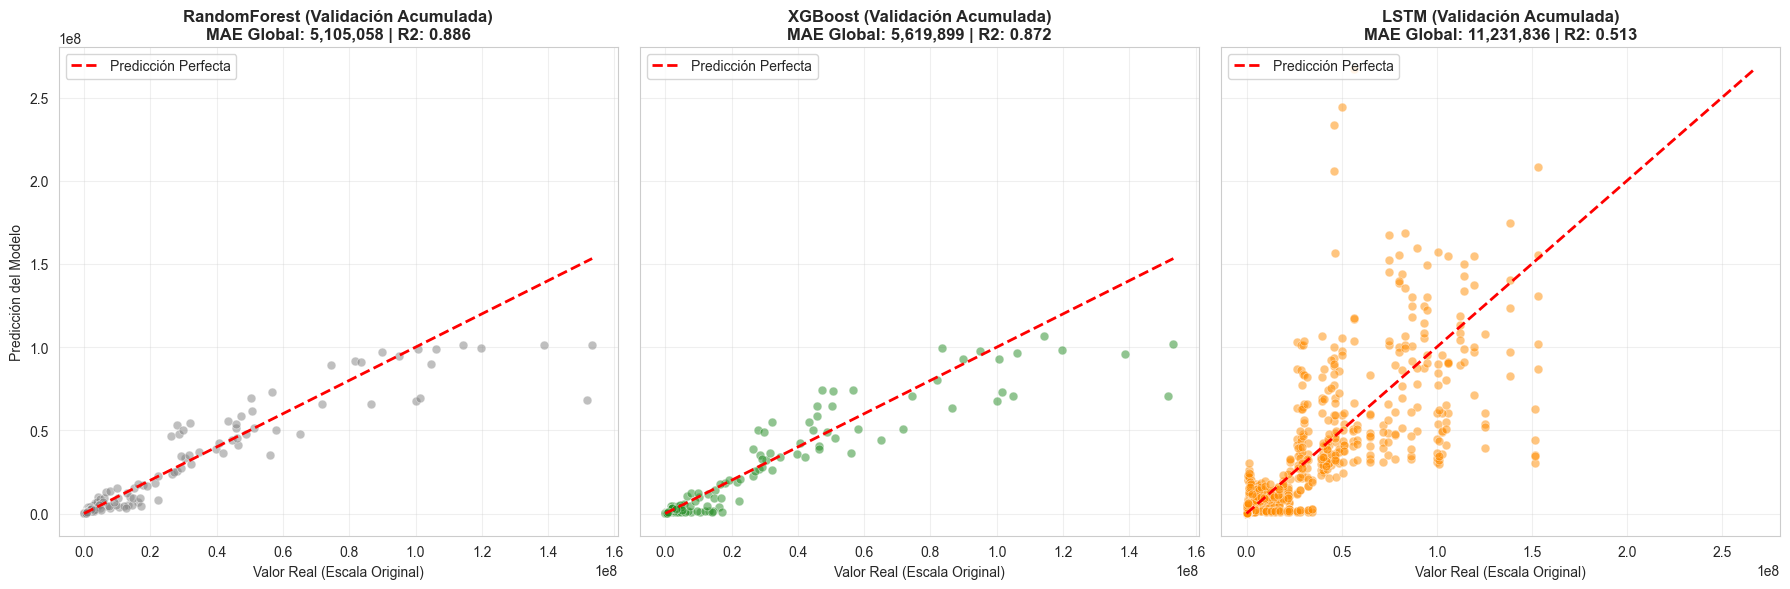

In [9]:
# =============================================================================
# 8. ANÁLISIS DE RESULTADOS Y GRÁFICOS (SIN REENTRENAMIENTO)
# =============================================================================
import matplotlib.pyplot as plt
import seaborn as sns

# 1. TABLA DE RESULTADOS
all_results = []
for model_name, entries in results_detailed.items():
    for res in entries:
        all_results.append({"model": model_name, **res})

if all_results:
    df_results = pd.DataFrame(all_results)
    
    print("\nResultados Detallados por Fold:")
    try:
        display(df_results.drop(columns=['hyperparameters']))
    except:
        print(df_results.drop(columns=['hyperparameters']))
    
    print("\n" + "="*50)
    
    # Resumen Estadístico
    metric_cols = [c for c in ["MAE", "RMSE", "R2", "MAPE"] if c in df_results.columns]
    summary = df_results.groupby("model")[metric_cols].agg(['mean', 'std'])
    
    print("RESUMEN DE RENDIMIENTO (Media +/- Desviación Estándar):")
    try:
        display(summary)
    except:
        print(summary)
    print("="*50)
    
    # Selección del Ganador
    summary_flat = summary.copy()
    summary_flat.columns = ['_'.join(col).strip() for col in summary_flat.columns.values]
    
    best_model_name = summary_flat['MAE_mean'].idxmin()
    best_model_stats = summary_flat.loc[best_model_name]
    
    print(f"\n🏆 MEJOR MODELO SELECCIONADO: {best_model_name}")
    print(f"   MAE Promedio: {best_model_stats['MAE_mean']:,.2f} (+/- {best_model_stats['MAE_std']:,.2f})")

    # -----------------------------------------------------------------------------
    # 2. GRÁFICO COMPARATIVO (USANDO DATOS ACUMULADOS DE FOLDS)
    # -----------------------------------------------------------------------------
    print("\n" + "="*50)
    print("📊 GENERANDO GRÁFICO ACUMULADO DE VALIDACIÓN")
    
    # Filtramos solo modelos que tienen datos guardados
    models_to_plot = [m for m in predictions_log.keys() if len(predictions_log[m]['y_true']) > 0]
    n_models = len(models_to_plot)
    
    if n_models > 0:
        fig, axes = plt.subplots(1, n_models, figsize=(6 * n_models, 6), sharey=True)
        if n_models == 1: axes = [axes]
        else: axes = axes.flatten()
        
        colors_map = {'Random Forest': 'royalblue', 'XGBoost': 'forestgreen', 'LSTM': 'darkorange'}
        
        for i, model in enumerate(models_to_plot):
            ax = axes[i]
            
            # Recuperamos los datos acumulados de los 5 folds
            y_t_log = np.array(predictions_log[model]['y_true'])
            y_p_log = np.array(predictions_log[model]['y_pred'])
            
            # Deshacer Logaritmo (Para ver escala real en la tesis)
            real = np.expm1(y_t_log)
            pred = np.expm1(y_p_log)
            
            # Scatter Plot
            color = colors_map.get(model, 'gray')
            sns.scatterplot(x=real, y=pred, alpha=0.5, color=color, ax=ax, s=40)
            
            # Línea de perfección (Identidad)
            max_val = max(real.max(), pred.max())
            min_val = min(real.min(), pred.min())
            ax.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Predicción Perfecta')
            
            # Métricas Globales (sobre todos los folds unidos)
            mae_global = np.mean(np.abs(real - pred))
            r2_global = r2_score(real, pred)
            
            ax.set_title(f"{model} (Validación Acumulada)\nMAE Global: {mae_global:,.0f} | R2: {r2_global:.3f}", 
                         fontsize=12, fontweight='bold')
            ax.set_xlabel("Valor Real (Escala Original)")
            if i == 0: ax.set_ylabel("Predicción del Modelo")
            ax.grid(True, alpha=0.3)
            ax.legend(loc='upper left')
        
        plt.tight_layout()
        plt.show()
    else:
        print("⚠️ No hay datos de predicción guardados para graficar.")

else:
    print("❌ Error: No se generaron resultados.")


############################################################
📊 ANÁLISIS DE RESULTADOS: Con Lags Target
############################################################

Resultados Detallados por Fold (Con Lags Target):


,model,MAE,RMSE,R2,MAPE,SMAPE,fold
0,RandomForest,7.705198e+06,1.041987e+07,0.463004,1.054162e+03,83.958750,1
1,RandomForest,7.869939e+06,1.786678e+07,0.780420,4.656628e+01,38.022385,2
2,RandomForest,3.087252e+06,5.880395e+06,0.951195,6.379055e+01,43.407328,3
3,RandomForest,1.251780e+06,1.715580e+06,0.982604,5.496636e+01,38.500708,4
4,RandomForest,5.611123e+06,1.246523e+07,0.935939,3.129611e+01,35.601120,5
5,XGBoost,8.726740e+06,1.169956e+07,0.323005,1.133254e+03,114.592484,1
6,XGBoost,8.152771e+06,1.786362e+07,0.780498,4.113090e+01,36.680620,2
7,XGBoost,3.634515e+06,8.156177e+06,0.906109,6.358420e+01,44.556931,3
8,XGBoost,1.381069e+06,1.980196e+06,0.976824,8.391138e+01,46.450083,4
9,XGBoost,6.204400e+06,1.313895e+07,0.928827,3.302778e+01,44.436788,5



RESUMEN DE RENDIMIENTO - Con Lags Target (Media +/- Desviación Estándar):


MAE                        RMSE                \
                      mean           std          mean           std   
model                                                                  
LSTM          1.028275e+07  5.122399e+06  2.159379e+07  9.157300e+06   
RandomForest  5.105058e+06  2.897442e+06  9.669572e+06  6.188632e+06   
XGBoost       5.619899e+06  3.095116e+06  1.056770e+07  5.930506e+06   

                    R2                    MAPE                
                  mean       std          mean           std  
model                                                         
LSTM          0.538313  0.416003  2.005925e+13  4.484965e+13  
RandomForest  0.822632  0.215681  2.501563e+02  4.496126e+02  
XGBoost       0.783053  0.267203  2.709816e+02  4.824354e+02


🏆 MEJOR MODELO EN ESCENARIO Con Lags Target: RandomForest
   MAE Promedio: 5,105,058.38 (+/- 2,897,442.20)

📊 GENERANDO GRÁFICO DE VALIDACIÓN: Con Lags Target


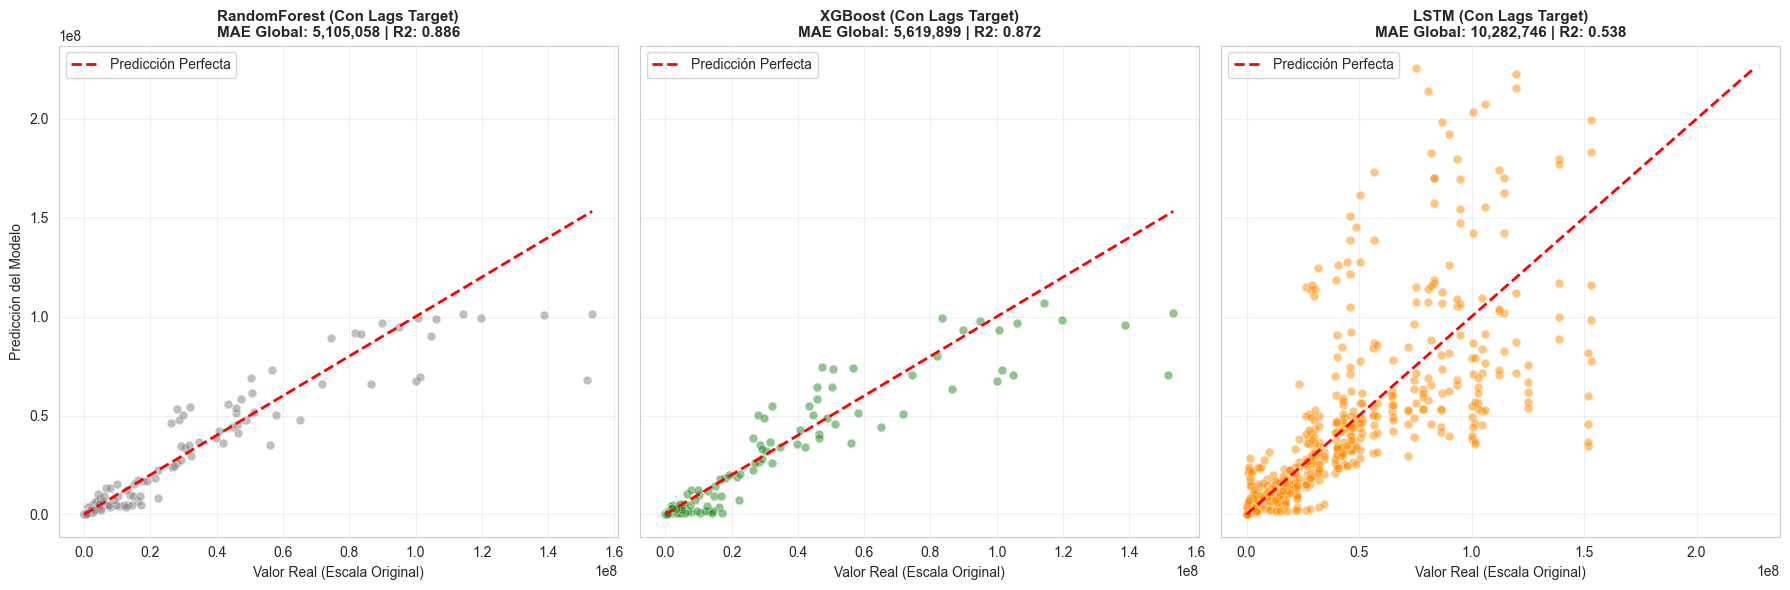


############################################################
📊 ANÁLISIS DE RESULTADOS: Sin Lags Target
############################################################

Resultados Detallados por Fold (Sin Lags Target):


,model,MAE,RMSE,R2,MAPE,SMAPE,fold
0,RandomForest,1.020008e+07,1.436306e+07,-0.020329,1107.179005,99.508863,1
1,RandomForest,1.483723e+07,2.574979e+07,0.543913,572.108253,87.693047,2
2,RandomForest,8.155884e+06,1.541940e+07,0.664430,95.227298,69.240834,3
3,RandomForest,8.100883e+06,9.929755e+06,0.417225,455.141629,100.902880,4
4,RandomForest,2.413783e+07,3.651300e+07,0.450345,444.751810,94.721243,5
5,XGBoost,1.096288e+07,1.614460e+07,-0.289143,1196.420161,116.842324,1
6,XGBoost,2.050636e+07,3.453772e+07,0.179483,432.428040,114.662075,2
7,XGBoost,9.458323e+06,1.873960e+07,0.504357,55.953391,62.131180,3
8,XGBoost,1.425226e+07,1.935813e+07,-1.214885,621.063558,116.190646,4
9,XGBoost,1.834442e+07,2.867000e+07,0.661116,397.978027,82.692184,5



RESUMEN DE RENDIMIENTO - Sin Lags Target (Media +/- Desviación Estándar):


MAE                        RMSE                \
                      mean           std          mean           std   
model                                                                  
RandomForest  1.308638e+07  6.758249e+06  2.039500e+07  1.071361e+07   
XGBoost       1.470485e+07  4.707367e+06  2.349001e+07  7.785851e+06   

                    R2                  MAPE              
                  mean       std        mean         std  
model                                                     
RandomForest  0.411117  0.259579  534.881599  366.294926  
XGBoost      -0.031814  0.754677  540.768635  419.374195


🏆 MEJOR MODELO EN ESCENARIO Sin Lags Target: RandomForest
   MAE Promedio: 13,086,380.78 (+/- 6,758,248.88)

📊 GENERANDO GRÁFICO DE VALIDACIÓN: Sin Lags Target


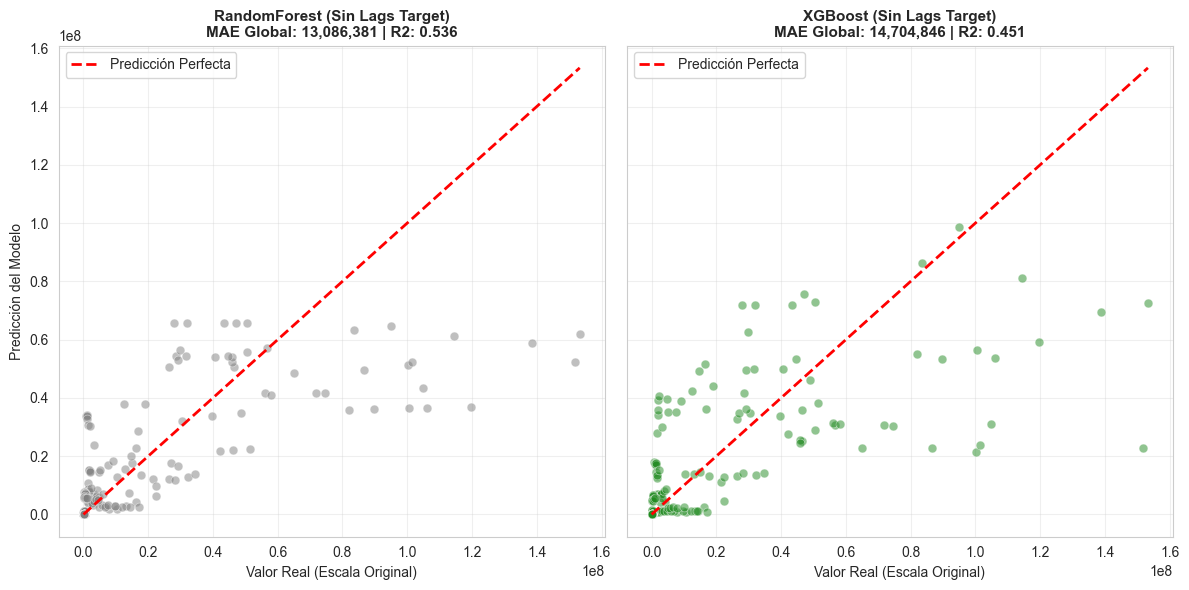

In [23]:
# =============================================================================
# 8. ANÁLISIS DE RESULTADOS Y GRÁFICOS (COMPARATIVA CON/SIN LAGS)
# =============================================================================
import matplotlib.pyplot as plt
import seaborn as sns

#Iteramos sobre los resultados de ambos escenarios guardados en Bloque 7
for nombre_esc, data in resultados_comparativos.items():
    print(f"\n" + "#"*60)
    print(f"📊 ANÁLISIS DE RESULTADOS: {nombre_esc}")
    print("#"*60 + "\n")

    # Extraemos las métricas y logs de este escenario específico
    results_detailed = data["metrics"]
    predictions_log = data["predictions"]

    # 1. TABLA DE RESULTADOS
    all_results = []
    for model_name, entries in results_detailed.items():
        for res in entries:
            all_results.append({"model": model_name, **res})

    if all_results:
        df_results = pd.DataFrame(all_results)
        
        print(f"Resultados Detallados por Fold ({nombre_esc}):")
        try:
            display(df_results.drop(columns=['hyperparameters']))
        except:
            print(df_results.drop(columns=['hyperparameters']))
        
        print("\n" + "="*50)
        
        # Resumen Estadístico
        metric_cols = [c for c in ["MAE", "RMSE", "R2", "MAPE"] if c in df_results.columns]
        summary = df_results.groupby("model")[metric_cols].agg(['mean', 'std'])
        
        print(f"RESUMEN DE RENDIMIENTO - {nombre_esc} (Media +/- Desviación Estándar):")
        try:
            display(summary)
        except:
            print(summary)
        print("="*50)
        
        # Selección del Ganador del escenario
        summary_flat = summary.copy()
        summary_flat.columns = ['_'.join(col).strip() for col in summary_flat.columns.values]
        
        best_model_name = summary_flat['MAE_mean'].idxmin()
        best_model_stats = summary_flat.loc[best_model_name]
        
        print(f"\n🏆 MEJOR MODELO EN ESCENARIO {nombre_esc}: {best_model_name}")
        print(f"   MAE Promedio: {best_model_stats['MAE_mean']:,.2f} (+/- {best_model_stats['MAE_std']:,.2f})")

        # -----------------------------------------------------------------------------
        # 2. GRÁFICO COMPARATIVO POR ESCENARIO
        # -----------------------------------------------------------------------------
        print("\n" + "="*50)
        print(f"📊 GENERANDO GRÁFICO DE VALIDACIÓN: {nombre_esc}")
        
        models_to_plot = [m for m in predictions_log.keys() if len(predictions_log[m]['y_true']) > 0]
        n_models = len(models_to_plot)
        
        if n_models > 0:
            fig, axes = plt.subplots(1, n_models, figsize=(6 * n_models, 6), sharey=True)
            if n_models == 1: axes = [axes]
            else: axes = axes.flatten()
            
            colors_map = {'Random Forest': 'royalblue', 'XGBoost': 'forestgreen', 'LSTM': 'darkorange'}
            
            for i, model in enumerate(models_to_plot):
                ax = axes[i]
                
                y_t_log = np.array(predictions_log[model]['y_true'])
                y_p_log = np.array(predictions_log[model]['y_pred'])
                
                real = np.expm1(y_t_log)
                pred = np.expm1(y_p_log)
                
                color = colors_map.get(model, 'gray')
                sns.scatterplot(x=real, y=pred, alpha=0.5, color=color, ax=ax, s=40)
                
                max_val = max(real.max(), pred.max())
                min_val = min(real.min(), pred.min())
                ax.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Predicción Perfecta')
                
                mae_global = np.mean(np.abs(real - pred))
                r2_global = r2_score(real, pred)
                
                ax.set_title(f"{model} ({nombre_esc})\nMAE Global: {mae_global:,.0f} | R2: {r2_global:.3f}", 
                             fontsize=11, fontweight='bold')
                ax.set_xlabel("Valor Real (Escala Original)")
                if i == 0: ax.set_ylabel("Predicción del Modelo")
                ax.grid(True, alpha=0.3)
                ax.legend(loc='upper left')
            
            plt.tight_layout()
            plt.show()
        else:
            print(f"⚠️ No hay datos de predicción para {nombre_esc}.")
    else:
        print(f"❌ No se generaron resultados para {nombre_esc}.")

In [11]:
# =============================================================================
# 9. ENTRENAMIENTO FINAL Y SIMULACIÓN 
# =============================================================================
print(f"\n--- 3. ENTRENAMIENTO FINAL (Estrategia: Mejor Configuración Histórica) ---")

# 1. Identificar la Mejor Configuración Específica
# Filtramos la tabla de resultados para ver solo el modelo ganador
df_winner = df_results[df_results['model'] == best_model_name]

# Buscamos la fila con el menor MAE (el "Mejor Fold")
best_row = df_winner.loc[df_winner['MAE'].idxmin()]
best_params_found = best_row['hyperparameters']
best_fold_origin = best_row['fold']

print(f"🏆 Modelo Ganador: {best_model_name}")
print(f"🎯 Configuración seleccionada del Fold {best_fold_origin} (MAE: {best_row['MAE']:.2f})")
print(f"⚙️ Parámetros a reutilizar: {best_params_found}")

# 2. PREPARACIÓN DE RECURSOS GLOBALES
final_model = None
scaler_lstm_X = None
scaler_lstm_y = None
imputer_lstm = None
look_back = 3 

# Preparar TODOS los datos Tabulares
imputer_tabular = IterativeImputer(random_state=SEED)
X_tab_imp = imputer_tabular.fit_transform(X_tab)
scaler_tabular = StandardScaler()
X_tab_sc = scaler_tabular.fit_transform(X_tab_imp)
y_tab_final = y_tab

# 3. ENTRENAMIENTO DEL MODELO FINAL (SIN RE-OPTIMIZAR)
if best_model_name == 'RandomForest':
    # Desempaquetamos los parámetros ganadores (**best_params_found)
    final_model = RandomForestRegressor(**best_params_found, random_state=SEED, n_jobs=-1)
    final_model.fit(X_tab_sc, y_tab_final)

elif best_model_name == 'XGBoost':
    final_model = xgb.XGBRegressor(**best_params_found, random_state=SEED, n_jobs=-1, objective='reg:squarederror')
    final_model.fit(X_tab_sc, y_tab_final)

elif best_model_name == 'LSTM':
    print("Re-construyendo LSTM con parámetros óptimos...")
    p = best_params_found
    
    # Preparación de datos LSTM Globales
    imputer_lstm = IterativeImputer(random_state=SEED)
    df_raw_features_imp = imputer_lstm.fit_transform(df_raw[features_base])
    df_raw_imp = df_raw.copy()
    df_raw_imp[features_base] = df_raw_features_imp
    
    X_seq_all, y_seq_all, _, _ = create_lstm_sequences_global(df_raw_imp, features_base, TARGET, look_back)
    
    # Escalado LSTM
    scaler_lstm_X = StandardScaler()
    shape_x = X_seq_all.shape
    X_flat_sc = scaler_lstm_X.fit_transform(X_seq_all.reshape(-1, shape_x[2]))
    X_seq_sc = X_flat_sc.reshape(shape_x)
    
    scaler_lstm_y = StandardScaler()
    y_flat_sc = scaler_lstm_y.fit_transform(y_seq_all.reshape(-1, 1)).flatten()
    
    # Reconstruir modelo
    model = Sequential([
        LSTM(p["units"], activation=p["activation"], input_shape=(look_back, X_seq_sc.shape[2])),
        Dropout(p["dropout"]),
        Dense(1)
    ])
    opt = tf.keras.optimizers.Adam(learning_rate=p['lr'])
    model.compile(optimizer=opt, loss="mae")
    
    # Entrenar (usamos un poco más de epochs al tener más datos)
    model.fit(X_seq_sc, y_flat_sc, epochs=p["epochs"], batch_size=p["batch_size"], verbose=0)
    final_model = model

print("✅ Modelo Final Entrenado con Configuración Óptima.")

# =============================================================================
# MOTOR DE SIMULACIÓN RECURSIVA 
# =============================================================================
def recursive_simulation(model, df_raw, country, start_yr, end_yr, scenario_params):
    # 1. Copia histórica
    df_sim = df_raw[df_raw['country'] == country].copy()
    last_year_hist = df_sim['year'].max()
    
    # 2. Proyectar Exógenas
    future_years = list(range(start_yr, end_yr + 1))
    rows_future = []
    df_trend = df_sim.sort_values('year')
    
    for yr in future_years:
        row = {'country': country, 'year': yr}
        for col in features_base:
            # Tendencia lineal (últimos 5 años para capturar momentum reciente)
            vals = df_trend[col].dropna().tail(5).values
            if len(vals) > 1:
                z = np.polyfit(range(len(vals)), vals, 1)
                val = np.poly1d(z)(len(vals) + (yr - last_year_hist) - 1)
            else:
                val = vals[-1] if len(vals) > 0 else 0
            
            # Aplicar Escenarios
            if col in scenario_params:
                val *= scenario_params[col]
            
            if 'uso_internet' in col: val = np.clip(val, 0, 100)
            row[col] = val
        rows_future.append(row)
        df_trend = pd.concat([df_trend, pd.DataFrame([row])], ignore_index=True)
        
    df_future = pd.DataFrame(rows_future)
    df_future[TARGET] = 0 
    df_sim = pd.concat([df_sim, df_future], ignore_index=True).reset_index(drop=True)
    
    # 3. Predicción Recursiva
    for yr in future_years:
        # LÓGICA LSTM
        if best_model_name == 'LSTM':
            years_needed = list(range(yr - look_back, yr))
            window_df = df_sim[df_sim['year'].isin(years_needed)].sort_values('year')
            
            if len(window_df) < look_back: continue
                
            X_window = window_df[features_base].values
            if imputer_lstm: X_window = imputer_lstm.transform(X_window)
            X_window_sc = scaler_lstm_X.transform(X_window)
            
            X_input = X_window_sc.reshape(1, look_back, X_window_sc.shape[1])
            pred_sc = model.predict(X_input, verbose=0)[0][0]
            pred_log = scaler_lstm_y.inverse_transform([[pred_sc]])[0][0]

        # LÓGICA TABULAR (RF/XGB)
        else:
            df_dyn = create_temporal_features(df_sim, features_base)
            idx = df_dyn[df_dyn['year'] == yr].index[0]
            X_curr = df_dyn.loc[[idx], features_tabular]
            
            X_curr_imp = imputer_tabular.transform(X_curr)
            X_curr_sc = scaler_tabular.transform(X_curr_imp)
            pred_log = model.predict(X_curr_sc)[0]

        idx_target = df_sim[df_sim['year'] == yr].index
        df_sim.loc[idx_target, TARGET] = pred_log
        
    return df_sim




--- 3. ENTRENAMIENTO FINAL (Estrategia: Mejor Configuración Histórica) ---
🏆 Modelo Ganador: RandomForest
🎯 Configuración seleccionada del Fold 4 (MAE: 1251780.12)
⚙️ Parámetros a reutilizar: {'n_estimators': 300, 'min_samples_leaf': 5, 'max_features': 0.9, 'max_depth': 40}
✅ Modelo Final Entrenado con Configuración Óptima.



🚀 Iniciando Análisis de Sensibilidad para Colombia...
  -> Simulando: Base (Tendencial)...
  -> Simulando: Política +5%...
  -> Simulando: Política +10%...
  -> Simulando: Política +20%...


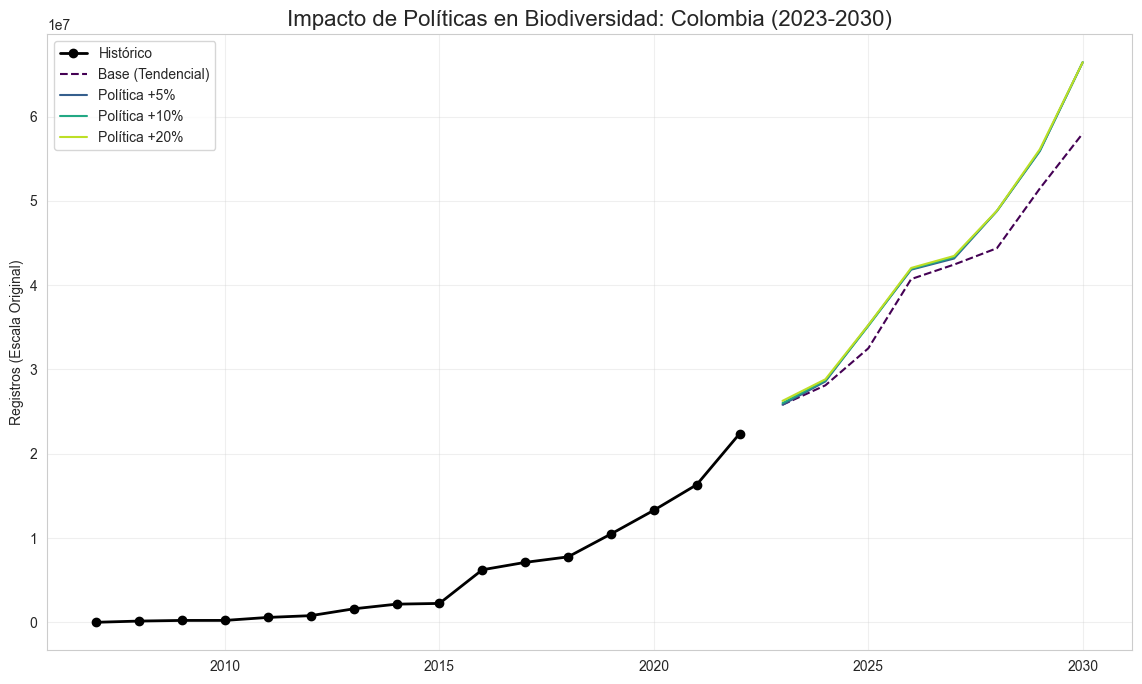


📊 TABLA COMPARATIVA DE ESCENARIOS:


,Escenario,Registros_2030,Crecimiento_%
0,Base (Tendencial),"57,992,590",+0.00%
1,Política +5%,"66,434,941",+14.56%
2,Política +10%,"66,434,941",+14.56%
3,Política +20%,"66,434,941",+14.56%


In [12]:
# =============================================================================
# 10 EJECUCIÓN DE ESCENARIOS MÚLTIPLES (ANÁLISIS DE SENSIBILIDAD)
# =============================================================================
target_country = 'Colombia'
start_proj = 2023
end_proj = 2030

print(f"\n🚀 Iniciando Análisis de Sensibilidad para {target_country}...")

# Definir variables a intervenir y niveles de intensidad
policy_vars = ['uso_internet', 'gasto_educacion_pib', 'investigadores_RD']
intensities = [0.00, 0.05, 0.10, 0.20] # Escenarios conservadores para evitar overfitting en extrapolación

results_data = []
scenario_dfs = {}

for intensity in intensities:
    multiplier = 1 + intensity
    scen_params = {var: multiplier for var in policy_vars} if intensity > 0 else {}
    scen_name = f"Política +{int(intensity*100)}%" if intensity > 0 else "Base (Tendencial)"
    
    print(f"  -> Simulando: {scen_name}...")
    df_res = recursive_simulation(final_model, df_raw, target_country, start_proj, end_proj, scen_params)
    scenario_dfs[scen_name] = df_res
    
    val_2030 = np.expm1(df_res.iloc[-1][TARGET])
    results_data.append({"Escenario": scen_name, "Registros_2030": val_2030})

# Visualización y Tabla
df_comparative = pd.DataFrame(results_data)
base_val = df_comparative.loc[0, "Registros_2030"]
df_comparative["Crecimiento_%"] = ((df_comparative["Registros_2030"] - base_val) / base_val) * 100

plt.figure(figsize=(14, 8))
hist = df_raw[df_raw['country'] == target_country]
plt.plot(hist['year'], np.expm1(hist[TARGET]), 'k-o', linewidth=2, label='Histórico')
colors = plt.cm.viridis(np.linspace(0, 0.9, len(intensities)))

for (name, df), color in zip(scenario_dfs.items(), colors):
    proj = df[df['year'] >= start_proj]
    style = '--' if "Base" in name else '-'
    plt.plot(proj['year'], np.expm1(proj[TARGET]), color=color, linestyle=style, label=name)

plt.title(f"Impacto de Políticas en Biodiversidad: {target_country} (2023-2030)", fontsize=16)
plt.ylabel("Registros (Escala Original)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print("\n📊 TABLA COMPARATIVA DE ESCENARIOS:")
display(df_comparative.style.format({"Registros_2030": "{:,.0f}", "Crecimiento_%": "{:+.2f}%"}))

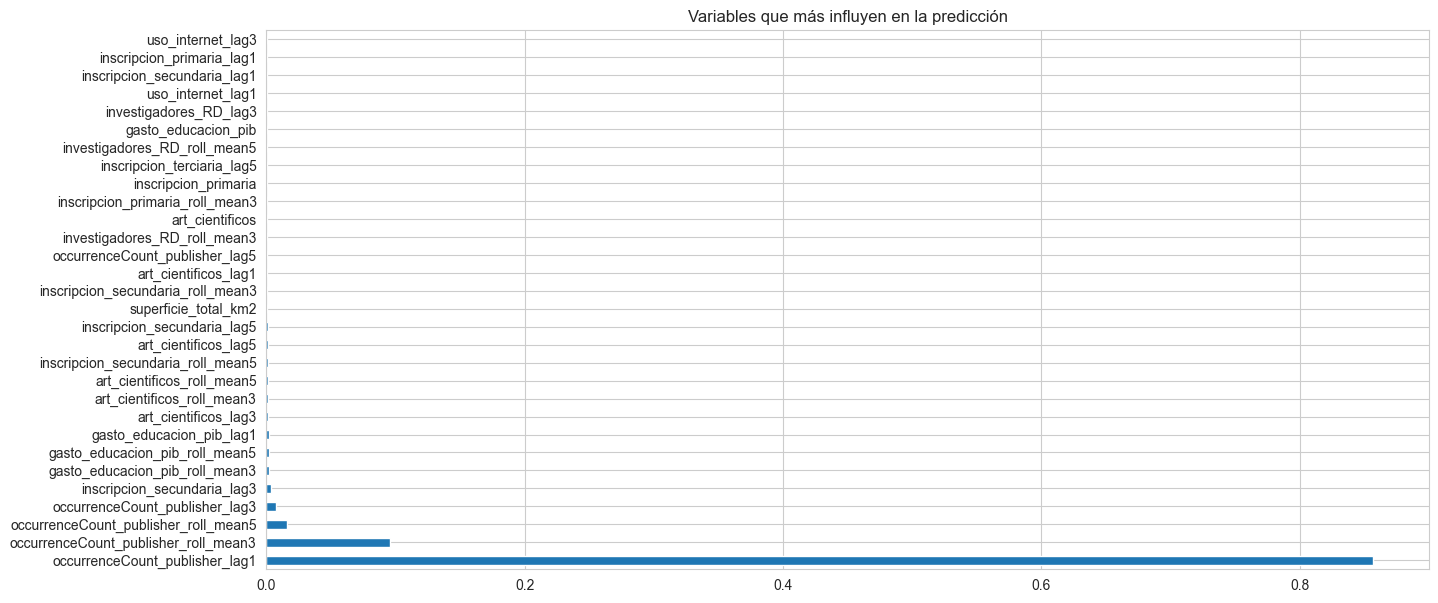

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

# Obtener importancia de variables
importances = final_model.feature_importances_
feat_imp = pd.Series(importances, index=features_tabular).sort_values(ascending=False)

# Graficar las 15 más importantes
feat_imp.head(30).plot(kind='barh')
plt.title("Variables que más influyen en la predicción")
plt.show()

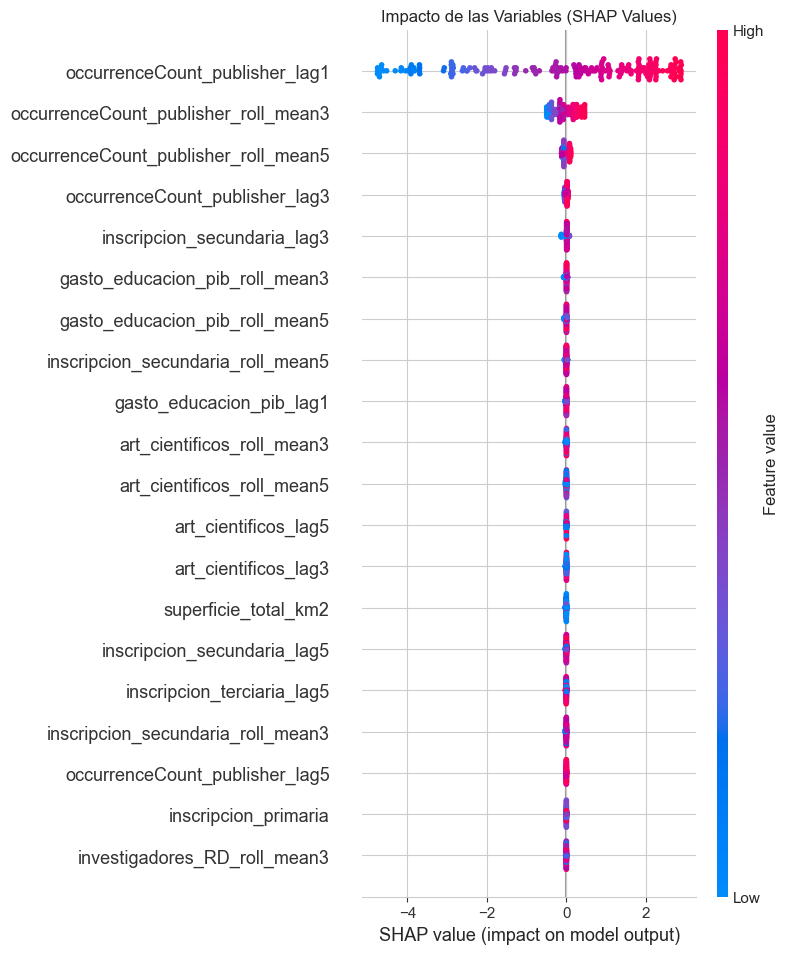

In [91]:
import shap

# 1. Crear el explicador (Explainer)
# Usamos TreeExplainer que es óptimo para RandomForest y XGBoost
explainer = shap.TreeExplainer(final_model)

# 2. Calcular los SHAP values sobre el set de datos escalados
# Usamos una muestra o todo el set de entrenamiento final (X_tab_sc)
shap_values = explainer.shap_values(X_tab_sc)

# 3. Gráfico de Resumen (Summary Plot)
# Este gráfico muestra el impacto de cada variable y su valor (alto/bajo)
plt.figure(figsize=(10, 10))
shap.summary_plot(shap_values, X_tab_sc, feature_names=features_tabular, show=False)
plt.title("Impacto de las Variables (SHAP Values)")
plt.show()


Prueba 2 

In [111]:
# =============================================================================
# REFINAMIENTO BLOQUE 9: MARCO HÍBRIDO CON RIDGE (ESTABILIZACIÓN)
# =============================================================================


print("--- 1. ETAPA HÍBRIDA: ENTRENAMIENTO CON RIDGE ---")

# A. Separación de Features (Inercia vs Estructura)
cols_inercia = [c for c in features_tabular if TARGET in c]
cols_estructural = [c for c in features_tabular if TARGET not in c]

# B. Preparación de datos (Imputación y Escalado)
imputer_hybrid = IterativeImputer(random_state=SEED)
X_hybrid_imp = imputer_hybrid.fit_transform(df_ml[cols_inercia + cols_estructural])
scaler_hybrid = StandardScaler()
X_hybrid_sc = scaler_hybrid.fit_transform(X_hybrid_imp)
X_hybrid_df = pd.DataFrame(X_hybrid_sc, columns=cols_inercia + cols_estructural)

# C. ETAPA 1: Modelo de Inercia usando RIDGE
# Alpha controla la suavidad: valores más altos (10, 20, 50) aplanan más la curva
model_inertia = Ridge(alpha=7.5, random_state=SEED)
model_inertia.fit(X_hybrid_df[cols_inercia], y_tab)

# Calcular Predicción de Inercia y Residuos
y_inertia_pred = model_inertia.predict(X_hybrid_df[cols_inercia])
y_residuals = y_tab - y_inertia_pred 

# D. ETAPA 2: Modelo de Residuos (Random Forest)
best_rf_params = results_detailed["RandomForest"][0]['hyperparameters']
model_dynamic = RandomForestRegressor(**best_rf_params, random_state=SEED, n_jobs=-1)
model_dynamic.fit(X_hybrid_df[cols_estructural], y_residuals)

print(f"✅ Modelo Híbrido reentrenado con Ridge (alpha=10).")

--- 1. ETAPA HÍBRIDA: ENTRENAMIENTO CON RIDGE ---
✅ Modelo Híbrido reentrenado con Ridge (alpha=10).


In [112]:
# =============================================================================
# BLOQUE 10: MOTOR DE SIMULACIÓN HÍBRIDA RECURSIVA (CORREGIDO)
# =============================================================================

cols_percent = ['gasto_RD_pib', 'gasto_educacion_pib', 'inscripcion_primaria', 'inscripcion_secundaria', 'inscripcion_terciaria','gasto_educacion_gobierno', 'areas_protegidas', 'uso_internet']

def recursive_simulation_hybrid(model_ml, model_ine, df_raw, country_name, start_yr, end_yr, scenario_params):
    # 1. Preparar DataFrame inicial con datos históricos del país
    df_sim = df_raw[df_raw['country'] == country_name].copy()
    last_year_hist = df_sim['year'].max()
    future_years = list(range(start_yr, end_yr + 1))
    
    # 2. Extrapolación de variables exógenas (Socioeconómicas)
    rows_future = []
    df_trend = df_sim.sort_values('year')
    for yr in future_years:
        row = {'country': country_name, 'year': yr}
        for col in features_base:
            # Tendencia de la variable exógena
            vals = df_trend[col].dropna().tail(5).values
            if len(vals) > 1:
                val = np.poly1d(np.polyfit(range(len(vals)), vals, 1))(len(vals) + (yr - last_year_hist) - 1)
            else:
                val = vals[-1] if len(vals) > 0 else 0
            
            # Aplicar intervención del escenario
            if col in scenario_params:
                val *= scenario_params[col]
            
            if col in cols_percent: val = np.clip(val, 0, 100)
            elif col == 'efectividad_gobierno':val = np.clip(val, -2.5, 2.5)
            elif val < 0: val = 0
            row[col] = val
        rows_future.append(row)
        df_trend = pd.concat([df_trend, pd.DataFrame([row])], ignore_index=True)
    
    df_proj = pd.concat([df_sim, pd.DataFrame(rows_future)], ignore_index=True).reset_index(drop=True)
    
    # 3. Predicción Recursiva Paso a Paso
    for yr in future_years:
        # Generamos los lags necesarios para este año
        df_temp = create_temporal_features(df_proj, features_base)
        idx = df_temp[df_temp['year'] == yr].index[0]
        
        # Preparar features para el modelo
        X_step = df_temp.loc[[idx], cols_inercia + cols_estructural]
        # Usamos los transformadores globales (scaler_hybrid e imputer_hybrid)
        X_step_sc = scaler_hybrid.transform(imputer_hybrid.transform(X_step))
        X_step_df = pd.DataFrame(X_step_sc, columns=cols_inercia + cols_estructural)
        
        # Predicción Etapa 1: Inercia (Usa el modelo Ridge pasado como argumento)
        pred_inertia = model_ine.predict(X_step_df[cols_inercia])[0]
        
        # Predicción Etapa 2: Dinámica (Usa el modelo RF pasado como argumento)
        pred_dynamic = model_ml.predict(X_step_df[cols_estructural])[0]
        
        # Combinación Híbrida
        y_final_log = pred_inertia + pred_dynamic
        
        # Actualizar el valor en el dataframe de proyección para el siguiente lag
        df_proj.loc[df_proj['year'] == yr, TARGET] = y_final_log
        
    return df_proj

print("✅ Motor de simulación híbrida listo y sincronizado.")

✅ Motor de simulación híbrida listo y sincronizado.


🚀 Generando proyecciones híbridas para Colombia...


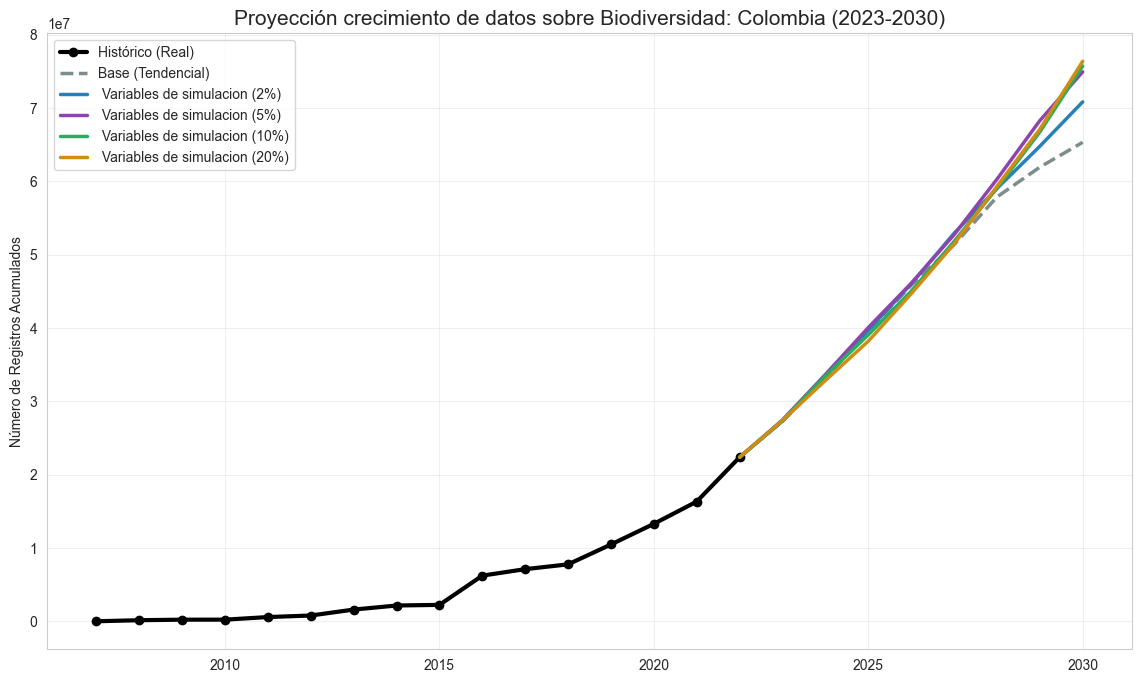


📊 TABLA DE RESULTADOS:


,Escenario,Registros 2030,Crecimiento vs Base (%)
0,Base (Tendencial),"65,313,771",+0.00%
1,Variables de simulacion (2%),"70,830,899",+8.45%
2,Variables de simulacion (5%),"74,923,523",+14.71%
3,Variables de simulacion (10%),"75,725,524",+15.94%
4,Variables de simulacion (20%),"76,364,508",+16.92%


In [129]:
# =============================================================================
# BLOQUE 11: SIMULACIÓN DE ESCENARIOS ESTRATÉGICOS (RESULTADOS FINALES)
# =============================================================================
target_country = 'Colombia'
start_proj, end_proj = 2023, 2030

intensidad_1 = 1.02 # Factor de incremento (10% sobre la tendencia)
intensidad_2 = 1.05 # Factor de incremento (10% sobre la tendencia)
intensidad_3 = 1.10 # Factor de incremento (10% sobre la tendencia)
intensidad_4 = 1.20 # Factor de incremento (10% sobre la tendencia)


# Panel de control de escenarios: Aquí puedes agregar o quitar variables según tu análisis
escenarios = {
    "Base (Tendencial)": {}, # Sin cambios 
    
    " Variables de simulacion (2%)": {
        'uso_internet': intensidad_1,
        'efectividad_gobierno': intensidad_1,
        'gasto_educacion_pib': intensidad_1,
        'inscripcion_primaria': intensidad_1,
        'inscripcion_secundaria': intensidad_1,
        'inscripcion_terciaria': intensidad_1,
        'art_cientificos': intensidad_1

    }, " Variables de simulacion (5%)": {
        'uso_internet': intensidad_2,
        'efectividad_gobierno': intensidad_2,
        'gasto_educacion_pib': intensidad_2,
        'inscripcion_primaria': intensidad_2,
        'inscripcion_secundaria': intensidad_2,
        'inscripcion_terciaria': intensidad_2,
        'art_cientificos': intensidad_2

    }, " Variables de simulacion (10%)": {
        'uso_internet': intensidad_3,
        'efectividad_gobierno': intensidad_3,
        'gasto_educacion_pib': intensidad_3,
        'inscripcion_primaria': intensidad_3,
        'inscripcion_secundaria': intensidad_3,
        'inscripcion_terciaria': intensidad_3,
        'art_cientificos': intensidad_3

    }, " Variables de simulacion (20%)": {
        'uso_internet': intensidad_4,
        'efectividad_gobierno': intensidad_4,
        'gasto_educacion_pib': intensidad_4,
        'inscripcion_primaria': intensidad_4,
        'inscripcion_secundaria': intensidad_4,
        'inscripcion_terciaria': intensidad_4,
        'art_cientificos': intensidad_4
}
}
# Ejecución del motor híbrido (Block 10)
resultados_finales = {}
tabla_resumen = []

print(f"🚀 Generando proyecciones híbridas para {target_country}...")

for nombre, params in escenarios.items():
    # Llamada al motor definido en el Bloque 10
    df_res = recursive_simulation_hybrid(
        model_dynamic, model_inertia, df_raw, 
        target_country, start_proj, end_proj, params
    )
    
    # Guardar resultados y convertir a escala real
    df_res['real_records'] = np.expm1(df_res[TARGET])
    resultados_finales[nombre] = df_res
    
    # Datos para la tabla comparativa final
    valor_2030 = df_res.iloc[-1]['real_records']
    tabla_resumen.append({"Escenario": nombre, "Registros 2030": valor_2030})

# --- VISUALIZACIÓN ---
plt.figure(figsize=(14, 8))
hist = df_raw[df_raw['country'] == target_country]
plt.plot(hist['year'], np.expm1(hist[TARGET]), 'k-o', label='Histórico (Real)', linewidth=3)

# Estilos de línea para diferenciar el Base de los demás
estilos = ['--', '-', '-', '-', '-']
colores = ['#7f8c8d', '#2980b9', '#8e44ad', '#27ae60',  "#cf8d11"]

for i, (nombre, df) in enumerate(resultados_finales.items()):
    proj = df[df['year'] >= 2022] # Mostrar desde el último punto real
    plt.plot(proj['year'], proj['real_records'], estilos[i], color=colores[i], label=nombre, linewidth=2.5)

plt.title(f"Proyección crecimiento de datos sobre Biodiversidad: {target_country} (2023-2030)", fontsize=15)
plt.ylabel("Número de Registros Acumulados")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# --- TABLA DE IMPACTO ---
df_impacto = pd.DataFrame(tabla_resumen)
base_val = df_impacto.loc[0, "Registros 2030"]
df_impacto["Crecimiento vs Base (%)"] = ((df_impacto["Registros 2030"] - base_val) / base_val) * 100

print("\n📊 TABLA DE RESULTADOS:")
display(df_impacto.style.format({
    "Registros 2030": "{:,.0f}", 
    "Crecimiento vs Base (%)": "{:+.2f}%"
}))

In [117]:
# =============================================================================
# BLOQUE 12: MÉTRICAS DE PRECISIÓN HISTÓRICA (BONDAD DE AJUSTE)
# =============================================================================


def obtener_metricas_precision(pais):
    df_p = df_ml[df_ml['country'] == pais].copy()
    
    # Preparar datos y predecir
    X_p = df_p[cols_inercia + cols_estructural]
    X_sc = scaler_hybrid.transform(imputer_hybrid.transform(X_p))
    X_df = pd.DataFrame(X_sc, columns=cols_inercia + cols_estructural)
    
    # Predicción Híbrida
    p_ine = model_inertia.predict(X_df[cols_inercia])
    p_res = model_dynamic.predict(X_df[cols_estructural])
    y_pred_log = p_ine + p_res
    
    # Volver a escala real
    y_real = np.expm1(df_p[TARGET].values)
    y_pred = np.expm1(y_pred_log)
    
    # Métricas
    mae = mean_absolute_error(y_real, y_pred)
    r2 = r2_score(y_real, y_pred)
    mape = np.mean(np.abs((y_real - y_pred) / y_real)) * 100
    
    return {"MAE": mae, "R2": r2, "MAPE": mape}

# Mostrar resultados
m = obtener_metricas_precision('Colombia')
print(f"--- Precisión del Modelo Híbrido (Ridge + RF) en Colombia ---")
print(f"MAE: {m['MAE']:,.0f} registros")
print(f"R2:  {m['R2']:.4f}")
print(f"MAPE: {m['MAPE']:.2f}%")

--- Precisión del Modelo Híbrido (Ridge + RF) en Colombia ---
MAE: 651,015 registros
R2:  0.9739
MAPE: 5.04%


📊 ANÁLISIS DESGLOSADO PARA COLOMBIA
----------------------------------------
ETAPA 1 (Inercia - Ridge):
  > R² (Capacidad de seguir la tendencia): 0.9044
  > MAE (Error en registros reales): 1,508,922
----------------------------------------
ETAPA 2 (Dinámica - Random Forest):
  > R² (Varianza residual explicada por innovación): 0.4718
  > El RF explica el 47.18% de lo que la historia no pudo explicar.
----------------------------------------
🧬 Generando SHAP para la Etapa de Innovación (Variables Socioeconómicas)...


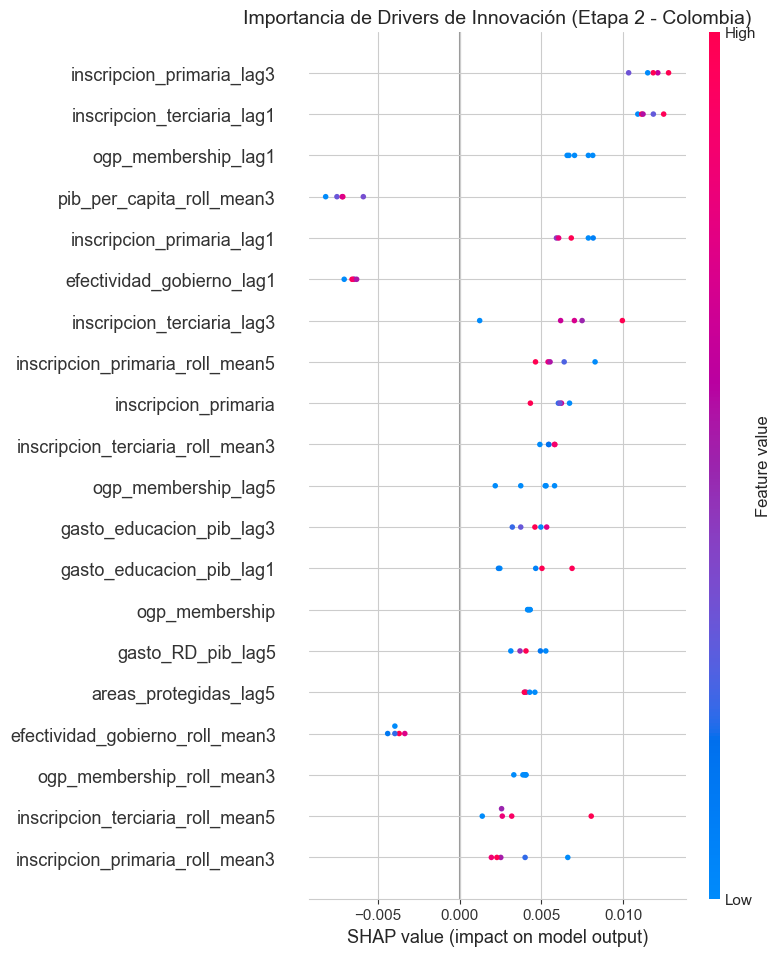

In [118]:
# =============================================================================
# BLOQUE 12-B: EVALUACIÓN DESGLOSADA (INERCIA VS INNOVACIÓN) + SHAP
# =============================================================================
import shap

def evaluar_etapas_separadas(pais='Colombia'):
    df_p = df_ml[df_ml['country'] == pais].copy()
    
    # 1. Preparación de datos
    X_p = df_p[cols_inercia + cols_estructural]
    X_sc = scaler_hybrid.transform(imputer_hybrid.transform(X_p))
    X_df = pd.DataFrame(X_sc, columns=cols_inercia + cols_estructural)
    
    # --- ETAPA 1: MÉTRICAS DE INERCIA (RIDGE) ---
    y_real_log = df_p[TARGET].values
    p_ine_log = model_inertia.predict(X_df[cols_inercia])
    
    r2_st1 = r2_score(y_real_log, p_ine_log)
    mae_st1 = mean_absolute_error(np.expm1(y_real_log), np.expm1(p_ine_log))
    
    # --- ETAPA 2: MÉTRICAS DE INNOVACIÓN (RF SOBRE RESIDUOS) ---
    y_res_real = y_real_log - p_ine_log  # El residuo real que el RF debía predecir
    p_res_pred = model_dynamic.predict(X_df[cols_estructural])
    
    r2_st2 = r2_score(y_res_real, p_res_pred)
    mae_st2 = mean_absolute_error(y_res_real, p_res_pred) # En escala logarítmica (magnitud del ajuste)

    print(f"📊 ANÁLISIS DESGLOSADO PARA {pais.upper()}")
    print("-" * 40)
    print(f"ETAPA 1 (Inercia - Ridge):")
    print(f"  > R² (Capacidad de seguir la tendencia): {r2_st1:.4f}")
    print(f"  > MAE (Error en registros reales): {mae_st1:,.0f}")
    print("-" * 40)
    print(f"ETAPA 2 (Dinámica - Random Forest):")
    print(f"  > R² (Varianza residual explicada por innovación): {r2_st2:.4f}")
    print(f"  > El RF explica el {r2_st2*100:.2f}% de lo que la historia no pudo explicar.")
    print("-" * 40)

    # --- GENERACIÓN DE SHAP PARA ETAPA 2 ---
    print(f"🧬 Generando SHAP para la Etapa de Innovación (Variables Socioeconómicas)...")
    explainer_res = shap.TreeExplainer(model_dynamic)
    shap_values_res = explainer_res.shap_values(X_df[cols_estructural])
    
    plt.figure(figsize=(10, 8))
    shap.summary_plot(shap_values_res, X_df[cols_estructural], 
                      feature_names=cols_estructural, show=False)
    plt.title(f"Importancia de Drivers de Innovación (Etapa 2 - {pais})", fontsize=14)
    plt.show()

# Ejecución
evaluar_etapas_separadas('Colombia')

--- Validación Ex-Post (2023-2025) ---
Error Medio Absoluto (MAE): 1,212,508 registros
Error Porcentual (MAPE): 3.29%


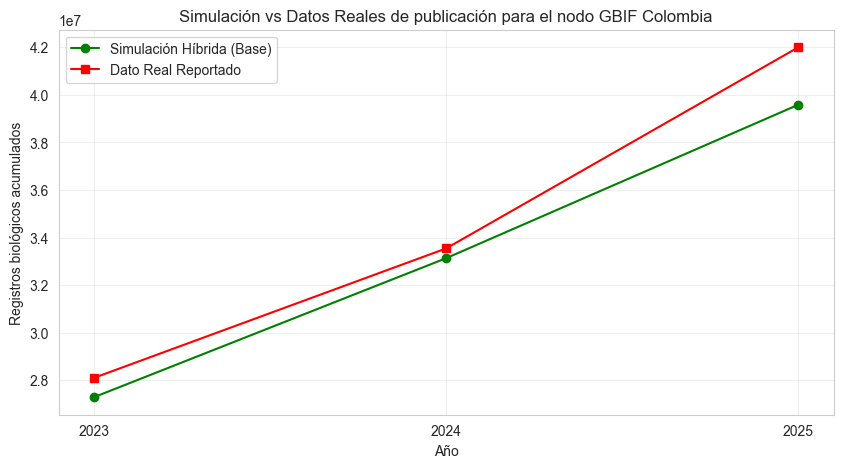

In [119]:
# =============================================================================
# BLOQUE 13: VALIDACIÓN EX-POST (SIMULADO VS REAL 2023-2025)
# =============================================================================

# Datos reales reportados para la validación
datos_reales_nuevos = {
    2023: 28099010, 
    2024: 33541980, 
    2025: 42000000 
}

# 1. Obtener los valores que el modelo simuló (usando la variable del Bloque 11 unificado)
# Cambiamos 'results_ridge' por 'resultados_finales' y el nombre del escenario
df_base = resultados_finales["Base (Tendencial)"]

# 2. Filtrar y preparar los datos para la comparación
simulados = df_base[df_base['year'].isin(datos_reales_nuevos.keys())].copy()
simulados['valor_real'] = simulados['year'].map(datos_reales_nuevos)
simulados['valor_simulado'] = np.expm1(simulados[TARGET])

# 3. Calcular errores de validación (Fuera de la muestra de entrenamiento)
mae_val = mean_absolute_error(simulados['valor_real'], simulados['valor_simulado'])
mape_val = np.mean(np.abs((simulados['valor_real'] - simulados['valor_simulado']) / simulados['valor_real'])) * 100

print(f"--- Validación Ex-Post ({min(datos_reales_nuevos.keys())}-{max(datos_reales_nuevos.keys())}) ---")
print(f"Error Medio Absoluto (MAE): {mae_val:,.0f} registros")
print(f"Error Porcentual (MAPE): {mape_val:.2f}%")

# 4. Visualización de la validación
plt.figure(figsize=(10, 5))
plt.plot(simulados['year'], simulados['valor_simulado'], 'g-o', label='Simulación Híbrida (Base)')
plt.plot(simulados['year'], simulados['valor_real'], 'r-s', label='Dato Real Reportado')

plt.title("Simulación vs Datos Reales de publicación para el nodo GBIF Colombia")
plt.xlabel("Año")
plt.ylabel("Registros biológicos acumulados")
plt.xticks(list(datos_reales_nuevos.keys()))
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [120]:
cols_percent = ['gasto_RD_pib', 'gasto_educacion_pib', 'inscripcion_primaria', 'inscripcion_secundaria', 'inscripcion_terciaria','gasto_educacion_gobierno', 'areas_protegidas', 'uso_internet']